In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder


In [34]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
# Load dataset
data = pd.read_csv('labeled_data.csv')


In [36]:
# Explore dataset
print("Dataset Overview:")
data.head()

Dataset Overview:


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [37]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None


In [38]:
# Check class distribution
print("\nClass Distribution:")
print(data['class'].value_counts())


Class Distribution:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


In [39]:
# Handle missing values
if data.isnull().values.any():
    print("Dataset contains missing values. Dropping missing entries.")
    data = data.dropna()

In [40]:
# Map labels to their names for better interpretability
data['class'] = data['class'].map({0: 'Hate Speech', 1: 'Offensive', 2: 'Neutral'})

In [41]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)


In [42]:
# Apply preprocessing
data['cleaned_text'] = data['tweet'].apply(preprocess_text)

In [43]:
# Display cleaned data
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,cleaned_text
0,0,3,0,0,3,Neutral,!!! RT @mayasolovely: As a woman you shouldn't...,rt woman shouldnt complain cleaning house amp ...
1,1,3,0,3,0,Offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dat coldtyga dwn bad cuffin dat hoe st ...
2,2,3,0,3,0,Offensive,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt ever fuck bitch start cry confused ...
3,3,3,0,2,1,Offensive,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt look like tranny
4,4,6,0,6,0,Offensive,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shit hear might true might faker bitch told ya


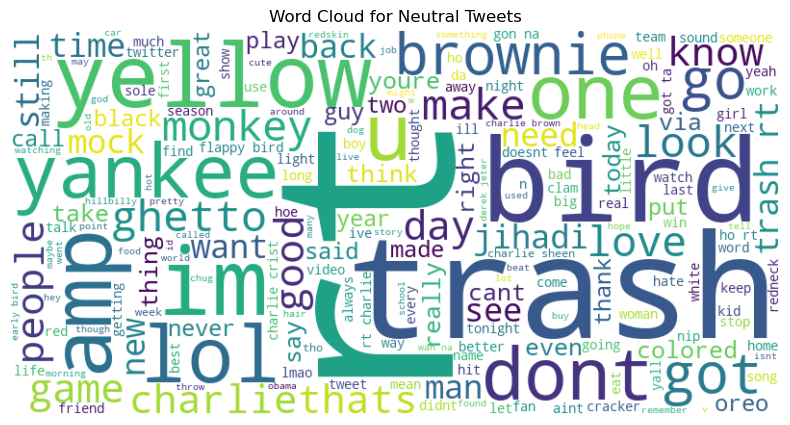

In [44]:
# Visualize Word Cloud for Neutral tweets
neutral_text = ' '.join(data[data['class'] == 'Neutral']['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Neutral Tweets")
plt.show()


In [45]:
# Split Data
X = data['cleaned_text']
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Print dataset sizes
print("Size of X_train:", X_train.shape)
print("Size of y_train:", y_train.shape)
print("Size of X_test:", X_test.shape)
print("Size of y_test:", y_test.shape)

Size of X_train: (19826,)
Size of y_train: (19826,)
Size of X_test: (4957,)
Size of y_test: (4957,)


In [47]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=100)
X_test_padded = pad_sequences(X_test_seq, maxlen=100)

In [48]:
# Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [62]:
# Build a Simple LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(units=64, dropout=0.2, recurrent_dropout=0.2),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=3, activation='softmax')  # 3 classes
])

In [110]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [111]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32, validation_split=0.1, class_weight=class_weights)

Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.9044 - loss: 0.6987 - val_accuracy: 0.8482 - val_loss: 0.5010
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.8517 - loss: 0.5443 - val_accuracy: 0.8411 - val_loss: 0.4971
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - accuracy: 0.8585 - loss: 0.4857 - val_accuracy: 0.8447 - val_loss: 0.4473
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.8637 - loss: 0.4135 - val_accuracy: 0.8396 - val_loss: 0.4726
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.8499 - loss: 0.3732 - val_accuracy: 0.8492 - val_loss: 0.4348
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - accuracy: 0.8574 - loss: 0.3340 - val_accuracy: 0.8497 - val_loss: 0.4267
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 55s 98ms/step - accuracy: 0.8698 - loss: 0.3220 - val_accuracy: 0.8462 - val_loss: 0.4435
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.8793 - loss: 0.2881 - 

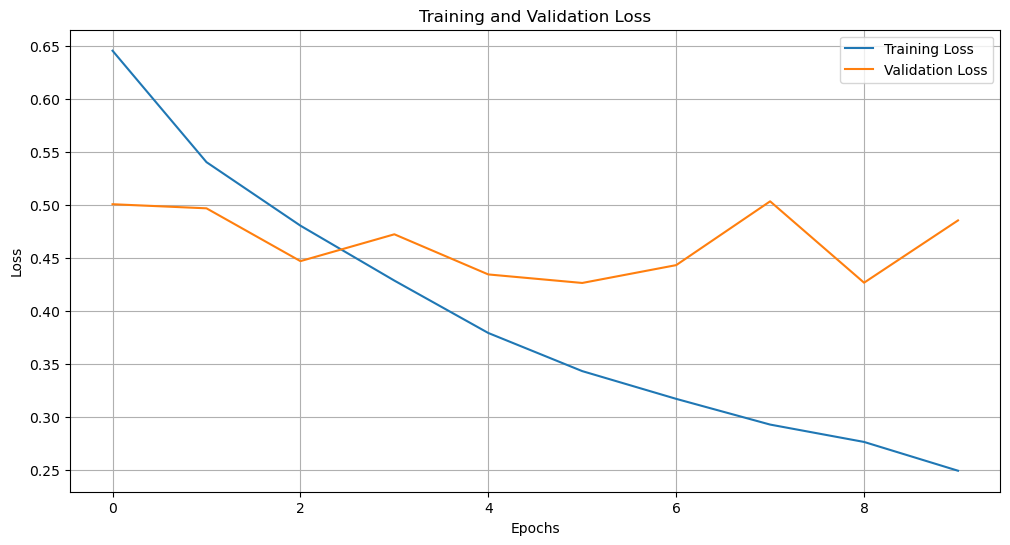

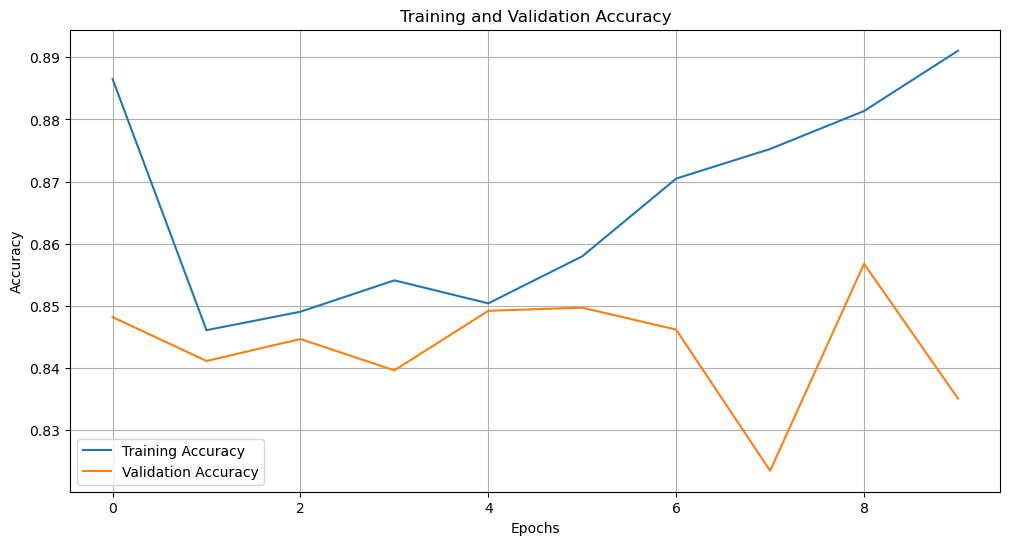

In [112]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [113]:
# Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8267 - loss: 0.4966
Test Loss: 0.53196781873703, Test Accuracy: 0.820052444934845


In [114]:
# Predictions on Test Data
y_pred_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


In [115]:
# Evaluate performance
print("\nAccuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))


Accuracy: 0.8200524510792818

Classification Report:
               precision    recall  f1-score   support

 Hate Speech       0.25      0.62      0.36       290
     Neutral       0.77      0.83      0.80       835
   Offensive       0.95      0.83      0.89      3832

    accuracy                           0.82      4957
   macro avg       0.66      0.76      0.68      4957
weighted avg       0.88      0.82      0.84      4957


Confusion Matrix:
 [[ 180   35   75]
 [  56  696   83]
 [ 474  169 3189]]


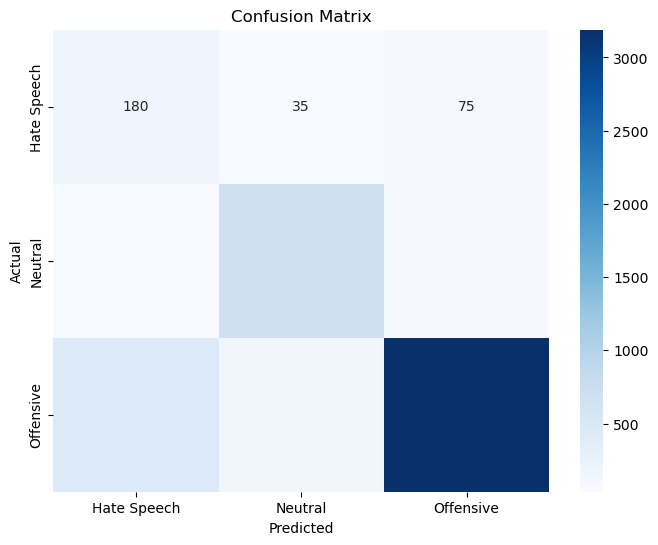

In [116]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

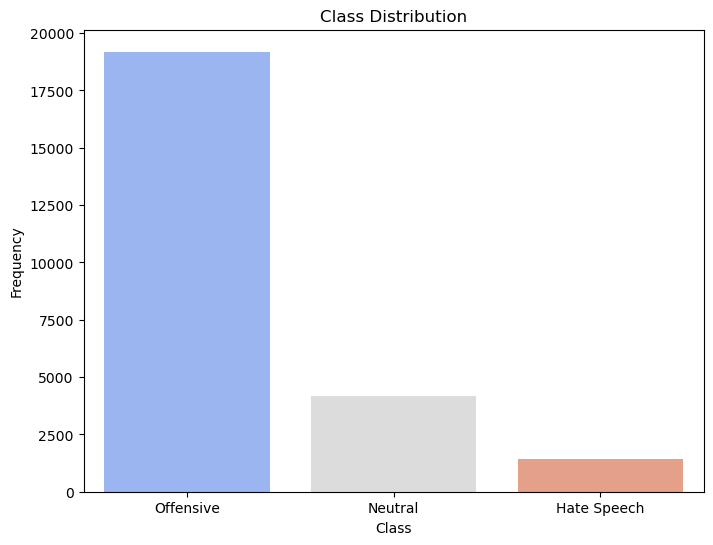

In [117]:
# Class Distribution Visualization
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data, order=data['class'].value_counts().index, palette='coolwarm')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [203]:
# Predict on New Data
new_data = ["This is a hateful comment", "I love this!", "This is a neutral statement", "You're a clown"]
new_data_cleaned = [preprocess_text(text) for text in new_data]  # Apply same preprocessing
new_data_seq = tokenizer.texts_to_sequences(new_data_cleaned)  # Tokenize
new_data_padded = pad_sequences(new_data_seq, maxlen=100)  # Pad sequences

In [204]:
# Get predictions for new data
predictions = model.predict(new_data_padded)
predicted_labels = predictions.argmax(axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [205]:
# Decode predicted labels
predicted_classes = label_encoder.inverse_transform(predicted_labels)

In [206]:
# Print predictions
for text, pred in zip(new_data, predicted_classes):
    print(f"Text: {text} - Predicted Class: {pred}")

Text: This is a hateful comment - Predicted Class: Hate Speech
Text: I love this! - Predicted Class: Neutral
Text: This is a neutral statement - Predicted Class: Neutral
Text: You're a clown - Predicted Class: Offensive
